In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [ ]:
import numpy as np
import os
import torch
from torchvision import datasets, transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from random import shuffle
import pandas as pd
from torch.utils.data import Dataset
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset Handling

## Fetching Dataset from Web-link

In [ ]:
!wget 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz' -P '/content/drive/MyDrive/DL_Assignment_2/'

--2022-02-18 10:47:47--  http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2640397119 (2.5G) [application/x-gzip]
Saving to: ‘/content/drive/MyDrive/DL_Assignment_2/stl10_binary.tar.gz’

stl10_binary.tar.gz 100%[===================>]   2.46G  35.5MB/s    in 1m 54s  

2022-02-18 10:49:41 (22.2 MB/s) - ‘/content/drive/MyDrive/DL_Assignment_2/stl10_binary.tar.gz’ saved [2640397119/2640397119]



## Unzipping the tar.gz file

In [ ]:
!tar -xvf  '/content/drive/MyDrive/DL_Assignment_2/stl10_binary.tar.gz' -C '/content/drive/MyDrive/DL_Assignment_2/Q_1'

stl10_binary/
stl10_binary/test_X.bin
stl10_binary/test_y.bin
stl10_binary/train_X.bin
stl10_binary/train_y.bin
stl10_binary/unlabeled_X.bin
stl10_binary/class_names.txt
stl10_binary/fold_indices.txt


## Utility Functions to open bin files and construct meta-file (image-name and labels)

In [ ]:
def bin_to_file(path):
  with open(path, 'rb') as f:
    file_open = np.fromfile(f,dtype=np.uint8)
    return file_open

def save_image_and_meta(directory, images_array, label_array):
  df = pd.DataFrame(columns=['Image_Name','Image_Class'])
  img_name_list=[]
  img_class_list=[]
  idx=0
  for image in tqdm(images_array):
    image = image.transpose((2,1,0))
    label = label_array[idx]
    img_name = 'Img_'+str(idx)+'.png'
    file_directory = directory+'/'+img_name
    img_name_list.append(img_name)
    img_class_list.append(label)
    idx = idx+1
    cv2.imwrite(file_directory,image)
  df['Image_Name']=img_name_list
  df['Image_Class']=img_class_list
  save_directory = directory+'meta.csv'
  df.to_csv(save_directory)

### X_Unsupervised

In [ ]:
x_u = bin_to_file('/content/drive/MyDrive/DL_Assignment_2/Q_1/stl10_binary/unlabeled_X.bin')
x_u = x_u.reshape((-1, 3, 96, 96))
x_u.shape

(100000, 3, 96, 96)

### X_Train

In [ ]:
x_train = bin_to_file('/content/drive/MyDrive/DL_Assignment_2/Q_1/stl10_binary/train_X.bin')
x_train = x_train.reshape((-1, 3, 96, 96))
x_train.shape

(5000, 3, 96, 96)

### X_Test

In [ ]:
x_test = bin_to_file('/content/drive/MyDrive/DL_Assignment_2/Q_1/stl10_binary/test_X.bin')
x_test = x_test.reshape((-1, 3, 96, 96))
x_test.shape

(8000, 3, 96, 96)

### Y_Train

In [ ]:
y_train = bin_to_file('/content/drive/MyDrive/DL_Assignment_2/Q_1/stl10_binary/train_y.bin')
y_train.shape

(5000,)

### Y_Test

In [ ]:
y_test = bin_to_file('/content/drive/MyDrive/DL_Assignment_2/Q_1/stl10_binary/test_y.bin')
y_test.shape

(8000,)

In [ ]:
save_image_and_meta('/content/drive/MyDrive/DL_Assignment_2/Q_1/train/',x_train,y_train)
save_image_and_meta('/content/drive/MyDrive/DL_Assignment_2/Q_1/test/',x_test,y_test)

100%|██████████| 8000/8000 [33:09<00:00,  4.02it/s] 


# Converting Dataset into Torch-Dataset, via Class Preparation and DataLoader

In [ ]:
class Data_Prepare(Dataset):
  """
  The Class will act as the container for our dataset. It will take your dataframe, the root path, and also the transform function for transforming the dataset.
  """
  def __init__(self, data_frame, root_dir, transform=None):
    self.data_frame = data_frame
    self.root_dir = root_dir
    self.transform = transform
  def __len__(self):
    # Return the length of the dataset
    return len(self.data_frame)
  def __getitem__(self, idx):
    # Return the observation based on an index. Ex. dataset[0] will return the first element from the dataset, in this case the image and the label.
    if torch.is_tensor(idx):
      idx = idx.tolist()    
    img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
    image = Image.open(img_name)
    label = (self.data_frame.iloc[idx, -1])-1
    if self.transform:
      image = self.transform(image)
    return (image, label)

def data_preparation(Data_Class, root_directory_train, root_directory_test, train_df, test_df, Mean, Std, Batch_Size = 128, Shuffle = False):
  transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(Mean, Std)])
  train_dataset = Data_Class(data_frame=train_df,root_dir=root_directory_train,transform = transform)
  train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = Batch_Size, shuffle = Shuffle, num_workers=2, pin_memory=True)
  test_dataset = Data_Class(data_frame=test_df,root_dir=root_directory_test,transform = transform)
  test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = Batch_Size, shuffle = Shuffle, num_workers=2, pin_memory=True)
  return train_loader, test_loader

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/DL_Assignment_2/Q_1/train/meta.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DL_Assignment_2/Q_1/test/meta.csv')
train_df = train_df.drop(columns=['Unnamed: 0'])
test_df = test_df.drop(columns=['Unnamed: 0'])

In [ ]:
train_df

,Image_Name,Image_Class
0,Img_0.png,2
1,Img_1.png,6
2,Img_2.png,2
3,Img_3.png,7
4,Img_4.png,4
...,...,...
4995,Img_4995.png,2
4996,Img_4996.png,6
4997,Img_4997.png,2
4998,Img_4998.png,8


In [ ]:
train,test = data_preparation(Data_Prepare, '/content/drive/MyDrive/DL_Assignment_2/Q_1/train', '/content/drive/MyDrive/DL_Assignment_2/Q_1/test', train_df, test_df, (0,0,0),(1,1,1), Batch_Size = 1024, Shuffle=True )

# Importing Pre-Trained ResNet-50

## Forward-passing Train and Test Images

In [ ]:
resnet_model = models.resnet50(pretrained=True).cuda()
for param in resnet_model.parameters():
  param.requires_grad = False

x_train = []
x_test = []

for (image, _) in train:
    image = image.cuda()
    out = resnet_model.forward(image)
    x_train.append(out)

for (image, _) in test:
    image = image.cuda()
    out = resnet_model.forward(image)
    x_test.append(out)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Converting Labels into CUDA-Labels

In [ ]:
label_train = []
label_test = []

for (_, label) in train:
    label_train.append(label.cuda())

for (_, label) in test:
    label_test.append(label.cuda())

# Converting Torch Matrix into Feature-Array

## X_Train

In [ ]:
x_train_array = x_train[0].cpu().numpy()
for i in x_train[1:]:
  x_train_array = np.concatenate((x_train_array,i.cpu().numpy()),axis=0)
x_train_array.shape

(5000, 1000)

## X_Test

In [ ]:
x_test_array = x_test[0].cpu().numpy()
for i in x_test[1:]:
  x_test_array = np.concatenate((x_test_array,i.cpu().numpy()),axis=0)
x_test_array.shape

(8000, 1000)

## Y_Train

In [ ]:
label_train_array = label_train[0].cpu().numpy()
for i in label_train[1:]:
  label_train_array = np.concatenate((label_train_array,i.cpu().numpy()),axis=0)
label_train_array.shape

(5000,)

## Y_Test

In [ ]:
label_test_array = label_test[0].cpu().numpy()
for i in label_test[1:]:
  label_test_array = np.concatenate((label_test_array,i.cpu().numpy()),axis=0)
label_test_array.shape

(8000,)

# Normalization Methods for variety of Distribution-related Trends

In [ ]:
ss = StandardScaler()
mms = MinMaxScaler()
ss.fit(x_train_array)
mms.fit(x_train_array)
x_train_array_ss = ss.transform(x_train_array)
x_train_array_mms = mms.transform(x_train_array)
x_test_array_ss = ss.transform(x_test_array)
x_test_array_mms = mms.transform(x_test_array)

# Confusion-Matrix and Overall Accuracy

In [ ]:
def first_subpart(pred, true):
  length = true.max()
  confusion_matrix = [[0 for i in range(length)] for j in range(length)]
  for row in range(0,len(true)):
    column = pred[row]
    confusion_matrix[true[row]-1][pred[row]-1] +=1
  print("Confusion Matrix\n")
  for i in confusion_matrix:
    print(i)
  print("\nOverall-Accuracy\n")
  correct=0
  for i in range(length):
    correct += confusion_matrix[i][i]
  print(str(correct*100/len(true))+"%")

## ROC-Curve for One-v/s-Rest Configuration

In [ ]:
def second_subpart(model_class, test_array, test_label):
  fpr = {}
  tpr = {}
  thresh ={}
  n_class = test_label.max()
  plt.figure(figsize=(10,10))
  for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_label, model_class.predict_proba(test_array)[:,i], pos_label=i)
    plt.plot(fpr[i], tpr[i], label='Class '+str(i)+' vs Rest')
  plt.title('Multiclass ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.show()

## RBF Kernel with Normalization Methods

In [ ]:
rbf = SVC(probability=True)
rbf.fit(x_train_array,label_train_array)
pred_rbf = rbf.predict(x_test_array)

In [ ]:
rbf_ss = SVC(probability=True)
rbf_ss.fit(x_train_array_ss,label_train_array)
pred_rbf_ss = rbf_ss.predict(x_test_array_ss)

In [ ]:
rbf_mms = SVC(probability=True)
rbf_mms.fit(x_train_array_mms,label_train_array)
pred_rbf_mms = rbf_mms.predict(x_test_array_mms)

In [ ]:
first_subpart(pred_rbf,label_test_array)

Confusion Matrix

[78, 83, 117, 86, 86, 83, 65, 89, 60, 53]
[77, 72, 109, 87, 83, 66, 68, 98, 66, 74]
[67, 92, 119, 79, 86, 88, 65, 77, 67, 60]
[77, 99, 113, 79, 83, 67, 70, 75, 76, 61]
[88, 72, 105, 92, 91, 77, 66, 82, 68, 59]
[91, 82, 94, 92, 79, 72, 69, 91, 70, 60]
[80, 88, 109, 85, 81, 81, 62, 88, 61, 65]
[60, 73, 117, 87, 93, 85, 72, 63, 71, 79]
[57, 66, 111, 88, 84, 77, 75, 90, 97, 55]
[71, 104, 134, 75, 62, 83, 74, 72, 72, 53]

Overall-Accuracy

9.825%


In [ ]:
first_subpart(pred_rbf_ss,label_test_array)

Confusion Matrix

[73, 80, 118, 92, 81, 83, 65, 92, 63, 53]
[77, 61, 109, 89, 87, 66, 72, 94, 69, 76]
[64, 89, 122, 88, 85, 92, 61, 79, 62, 58]
[79, 98, 106, 79, 88, 63, 74, 73, 81, 59]
[91, 76, 107, 95, 91, 75, 68, 75, 67, 55]
[88, 78, 94, 90, 82, 78, 65, 92, 71, 62]
[75, 87, 111, 84, 88, 76, 69, 84, 60, 66]
[61, 78, 112, 92, 96, 84, 70, 62, 73, 72]
[58, 60, 111, 91, 81, 78, 72, 89, 105, 55]
[68, 102, 139, 73, 59, 85, 75, 71, 77, 51]

Overall-Accuracy

9.8875%


In [ ]:
first_subpart(pred_rbf_mms,label_test_array)

Confusion Matrix

[72, 84, 107, 81, 94, 85, 65, 99, 59, 54]
[71, 66, 106, 90, 95, 63, 74, 99, 65, 71]
[61, 88, 111, 77, 94, 100, 60, 76, 68, 65]
[70, 99, 104, 73, 99, 69, 74, 82, 71, 59]
[87, 77, 100, 86, 106, 74, 70, 81, 67, 52]
[84, 85, 76, 93, 96, 76, 65, 93, 70, 62]
[77, 86, 105, 77, 93, 81, 69, 85, 59, 68]
[57, 74, 108, 77, 106, 84, 69, 66, 87, 72]
[64, 78, 104, 84, 86, 77, 77, 85, 89, 56]
[68, 96, 123, 76, 82, 88, 71, 74, 70, 52]

Overall-Accuracy

9.75%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


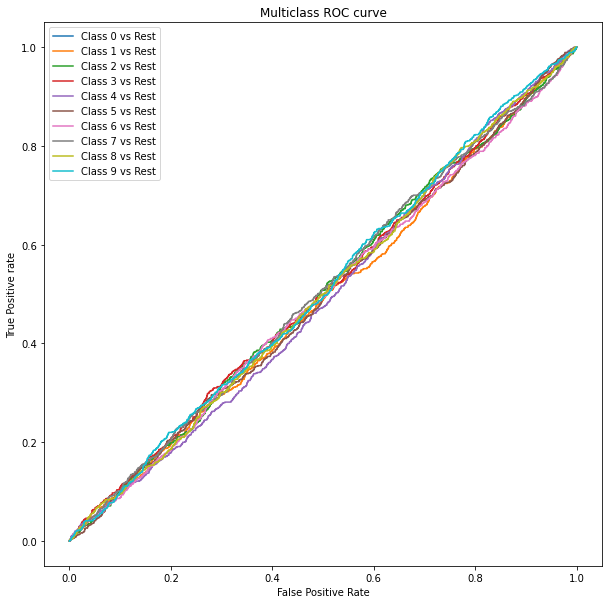

In [ ]:
second_subpart(rbf, x_test_array, label_test_array)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


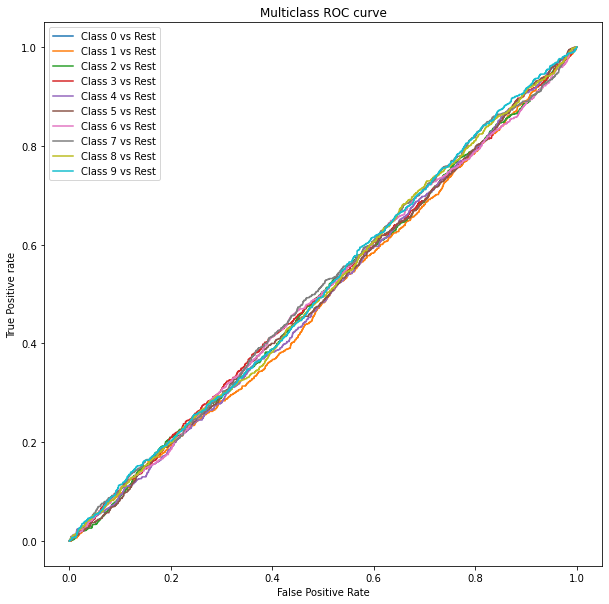

In [ ]:
second_subpart(rbf_ss, x_test_array_ss, label_test_array)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


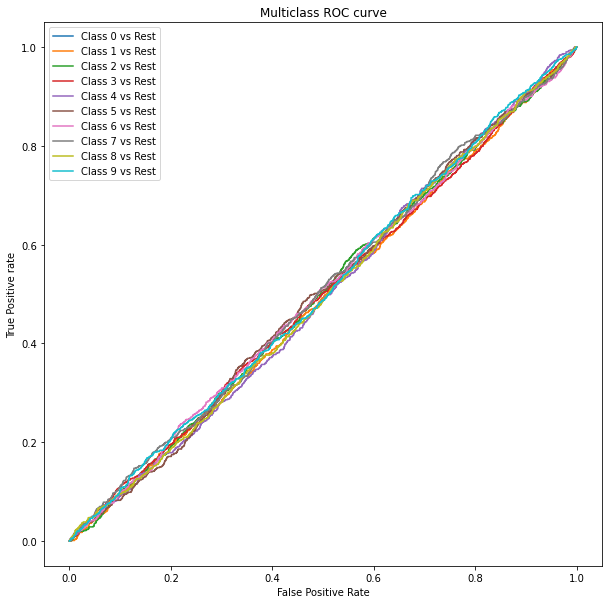

In [ ]:
second_subpart(rbf_mms, x_test_array_mms, label_test_array)

## Linear Kernel with Normalization Methods

In [ ]:
linear = SVC(kernel='linear', probability=True)
linear.fit(x_train_array,label_train_array)
pred_linear = linear.predict(x_test_array)

In [ ]:
linear_ss = SVC(kernel='linear', probability=True)
linear_ss.fit(x_train_array_ss,label_train_array)
pred_linear_ss = linear_ss.predict(x_test_array_ss)

In [ ]:
linear_mms = SVC(kernel='linear', probability=True)
linear_mms.fit(x_train_array_mms,label_train_array)
pred_linear_mms = linear_mms.predict(x_test_array_mms)

In [ ]:
first_subpart(pred_linear,label_test_array)

Confusion Matrix

[97, 96, 118, 74, 81, 75, 69, 70, 56, 64]
[77, 110, 98, 82, 97, 80, 62, 85, 56, 53]
[119, 110, 86, 88, 78, 72, 75, 71, 54, 47]
[99, 117, 102, 78, 79, 74, 83, 62, 47, 59]
[90, 94, 114, 95, 65, 68, 75, 75, 54, 70]
[95, 95, 85, 94, 96, 87, 73, 63, 46, 66]
[105, 111, 94, 87, 68, 78, 69, 73, 49, 66]
[106, 98, 92, 76, 80, 70, 77, 67, 61, 73]
[115, 103, 102, 90, 76, 71, 64, 62, 63, 54]
[91, 102, 102, 94, 76, 85, 47, 87, 60, 56]

Overall-Accuracy

9.725%


In [ ]:
first_subpart(pred_linear_ss,label_test_array)

Confusion Matrix

[104, 99, 113, 80, 89, 65, 70, 68, 63, 49]
[73, 104, 111, 86, 96, 55, 76, 81, 64, 54]
[104, 113, 91, 81, 76, 79, 74, 74, 56, 52]
[85, 110, 103, 81, 77, 74, 76, 62, 63, 69]
[93, 87, 89, 101, 82, 67, 76, 67, 68, 70]
[91, 102, 80, 89, 91, 68, 69, 82, 58, 70]
[115, 103, 90, 97, 70, 71, 81, 58, 58, 57]
[98, 92, 105, 74, 76, 73, 79, 74, 56, 73]
[108, 96, 96, 91, 80, 72, 78, 60, 63, 56]
[103, 114, 101, 87, 67, 77, 62, 71, 58, 60]

Overall-Accuracy

10.1%


In [ ]:
first_subpart(pred_linear_mms,label_test_array)

Confusion Matrix

[87, 105, 89, 98, 83, 76, 76, 69, 62, 55]
[95, 114, 89, 89, 86, 55, 67, 80, 49, 76]
[95, 112, 94, 74, 82, 64, 74, 78, 50, 77]
[99, 103, 97, 73, 88, 69, 72, 79, 54, 66]
[101, 119, 90, 89, 83, 66, 70, 60, 63, 59]
[105, 98, 85, 88, 110, 61, 75, 58, 49, 71]
[122, 98, 78, 85, 79, 70, 76, 69, 46, 77]
[76, 101, 99, 73, 90, 62, 83, 63, 70, 83]
[80, 98, 92, 80, 81, 86, 82, 61, 59, 81]
[91, 128, 93, 72, 74, 87, 69, 73, 44, 69]

Overall-Accuracy

9.7375%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


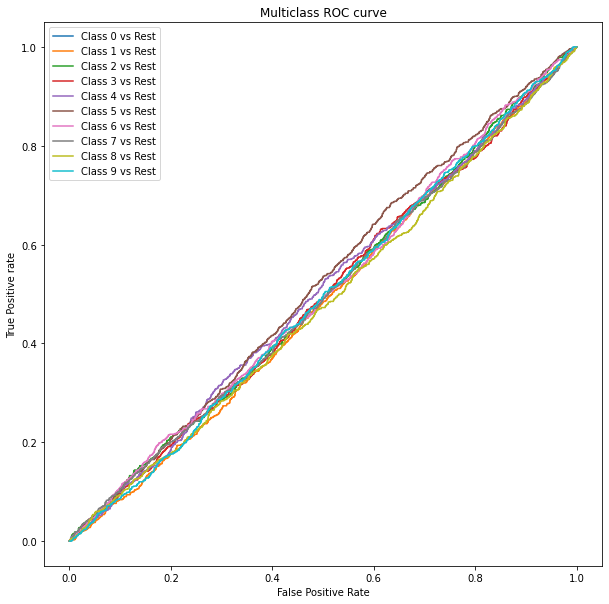

In [ ]:
second_subpart(linear, x_test_array, label_test_array)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


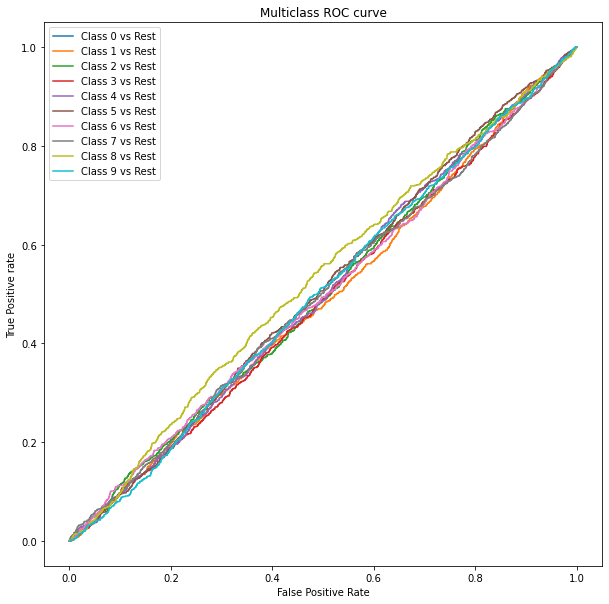

In [ ]:
second_subpart(linear_ss, x_test_array_ss, label_test_array)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


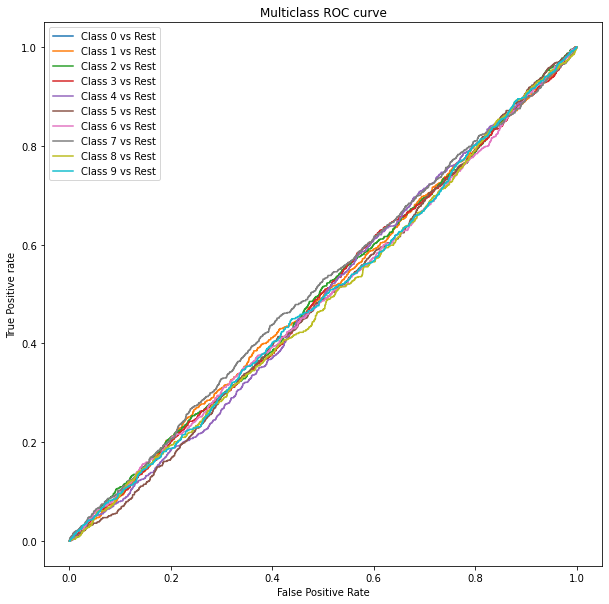

In [ ]:
second_subpart(linear_mms, x_test_array_mms, label_test_array)

## 3rd Degree Polynomial (Cubic) Kernel with Normalization Methods

In [ ]:
poly = SVC(kernel='poly', degree=3, probability=True)
poly.fit(x_train_array,label_train_array)
pred_poly = poly.predict(x_test_array)

In [ ]:
poly_ss = SVC(kernel='poly', degree=3, probability=True)
poly_ss.fit(x_train_array_ss,label_train_array)
pred_poly_ss = poly_ss.predict(x_test_array_ss)

In [ ]:
poly_mms = SVC(kernel='poly', degree=3, probability=True)
poly_mms.fit(x_train_array_mms,label_train_array)
pred_poly_mms = poly_mms.predict(x_test_array_mms)

In [ ]:
first_subpart(pred_poly,label_test_array)

Confusion Matrix

[33, 59, 60, 38, 283, 39, 40, 147, 37, 64]
[43, 53, 56, 39, 285, 37, 38, 142, 40, 67]
[37, 46, 66, 47, 278, 63, 28, 140, 30, 65]
[36, 63, 52, 51, 297, 38, 38, 119, 37, 69]
[45, 51, 50, 33, 292, 38, 26, 144, 47, 74]
[40, 48, 54, 40, 294, 48, 30, 139, 35, 72]
[52, 56, 47, 43, 274, 43, 34, 135, 47, 69]
[40, 49, 50, 37, 282, 58, 26, 128, 57, 73]
[29, 48, 67, 42, 278, 41, 39, 150, 44, 62]
[38, 52, 66, 43, 268, 62, 38, 110, 44, 79]

Overall-Accuracy

10.35%


In [ ]:
first_subpart(pred_poly_ss,label_test_array)

Confusion Matrix

[37, 64, 53, 43, 271, 36, 38, 150, 34, 74]
[53, 53, 65, 33, 276, 35, 34, 134, 46, 71]
[43, 58, 62, 49, 262, 45, 30, 134, 45, 72]
[41, 66, 55, 48, 271, 39, 40, 116, 46, 78]
[33, 66, 58, 29, 283, 46, 30, 132, 54, 69]
[39, 50, 44, 37, 290, 46, 38, 124, 57, 75]
[45, 55, 48, 48, 265, 37, 42, 142, 50, 68]
[43, 56, 57, 34, 283, 40, 35, 116, 54, 82]
[44, 58, 62, 47, 271, 34, 43, 134, 42, 65]
[26, 59, 68, 40, 253, 50, 46, 127, 48, 83]

Overall-Accuracy

10.15%


In [ ]:
first_subpart(pred_poly_mms,label_test_array)

Confusion Matrix

[105, 92, 95, 85, 73, 92, 64, 74, 62, 58]
[76, 97, 92, 100, 93, 65, 69, 80, 74, 54]
[100, 115, 96, 78, 63, 74, 65, 70, 62, 77]
[95, 94, 101, 89, 62, 75, 86, 62, 65, 71]
[98, 86, 95, 98, 74, 74, 80, 55, 72, 68]
[97, 90, 100, 99, 74, 70, 70, 73, 55, 72]
[95, 93, 86, 79, 70, 75, 80, 87, 67, 68]
[99, 92, 107, 87, 71, 69, 80, 63, 62, 70]
[92, 95, 100, 87, 71, 77, 74, 62, 78, 64]
[89, 91, 107, 89, 72, 75, 77, 58, 78, 64]

Overall-Accuracy

10.2%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


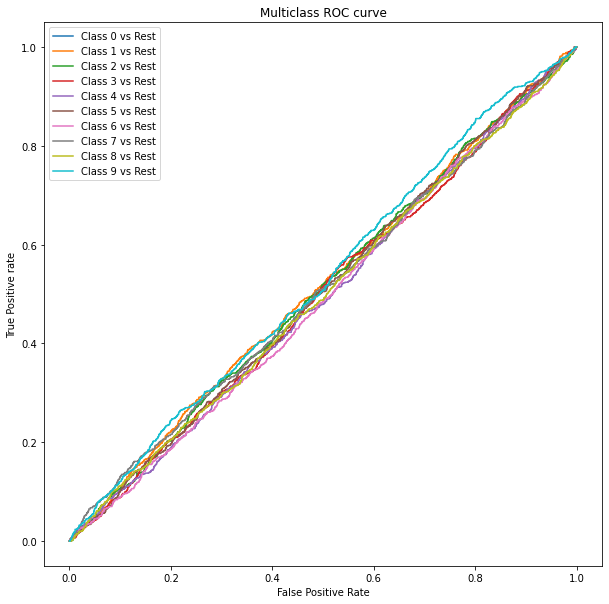

In [ ]:
second_subpart(poly, x_test_array, label_test_array)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


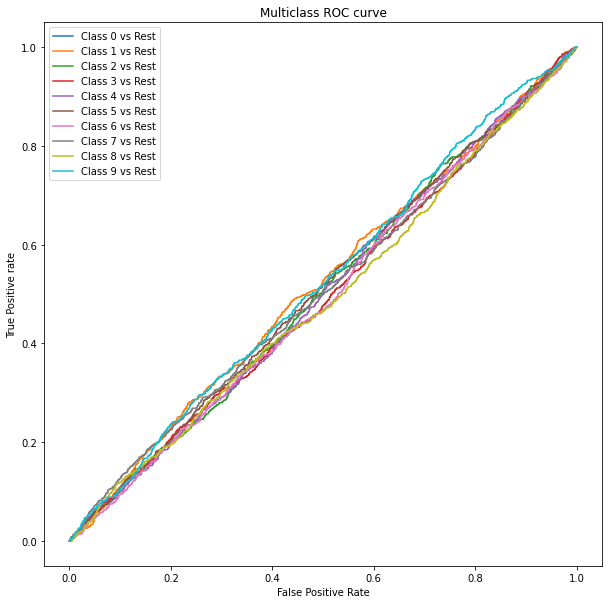

In [ ]:
second_subpart(poly_ss, x_test_array_ss, label_test_array)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


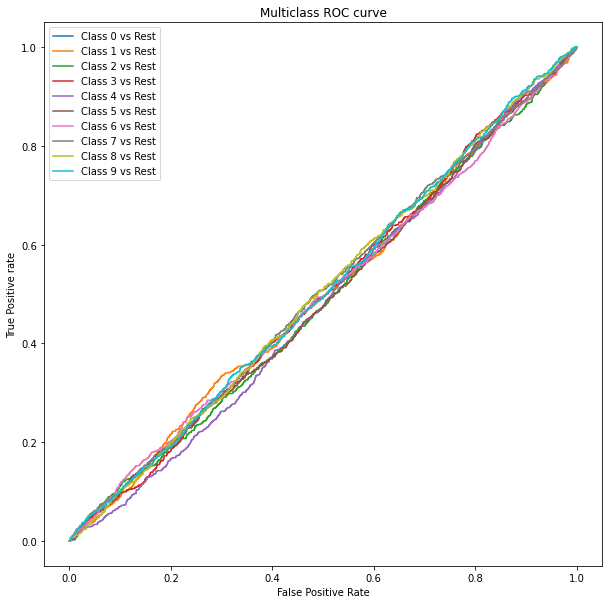

In [ ]:
second_subpart(poly_mms, x_test_array_mms, label_test_array)

# Utility Functions to Train a Pytorch Model

In [ ]:
def grad_change(Loss_Function, Optimizer, Label = None, Predicted = None):
  Optimizer.zero_grad()
  loss = Loss_Function(Predicted, Label)
  loss.backward()
  Optimizer.step()
  return loss, Optimizer

def model(Train_Loader, Test_Loader, Epochs, Model_Class=None, Loss_Function=None, Optimizer=None):
  outputs_train=[]
  outputs_test=[]
  for Epoch in range(Epochs):
    running_loss_train=0
    running_loss_test=0
    correct_train=0
    correct_test=0
    for (image, label) in Train_Loader:
      image = image.cuda()
      label = label.cuda()
      out = Model_Class(image)
      loss, Optimizer = grad_change(Loss_Function = Loss_Function, Optimizer = Optimizer, Label = label, Predicted = out)
      running_loss_train += loss.item()
      predicted_train = out.data.max(1, keepdim=True)[1]
      correct_train += predicted_train.eq(label.data.view_as(predicted_train)).sum()
    outputs_train.append((Epoch, running_loss_train/len(Train_Loader.dataset), 100*correct_train/len(Train_Loader.dataset)))
    with torch.no_grad():
      for (image, label) in Test_Loader:
        image = image.cuda()
        label = label.cuda()
        out = Model_Class(image)
        loss = Loss_Function(out,label)
        running_loss_test += loss.item()
        predicted_test = out.data.max(1, keepdim=True)[1]
        correct_test += predicted_test.eq(label.data.view_as(predicted_test)).sum()
      outputs_test.append((Epoch, running_loss_test/len(Test_Loader.dataset), 100*correct_test/len(Test_Loader.dataset)))
  return Model_Class, outputs_train, outputs_test

# Default ResNet Configuration

In [ ]:
resnet_model_default = models.resnet50(pretrained=True)
for param in resnet_model_default.parameters():
    param.requires_grad = False

resnet_model_default.fc = torch.nn.Linear(2048,10)
resnet_model_default.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
loss_function = torch.nn.CrossEntropyLoss().cuda()
optimizer_default = torch.optim.Adam(resnet_model_default.fc.parameters())
resnet_model_default,output_train_default,output_test_default = model(train,test,15,resnet_model_default,loss_function,optimizer_default)

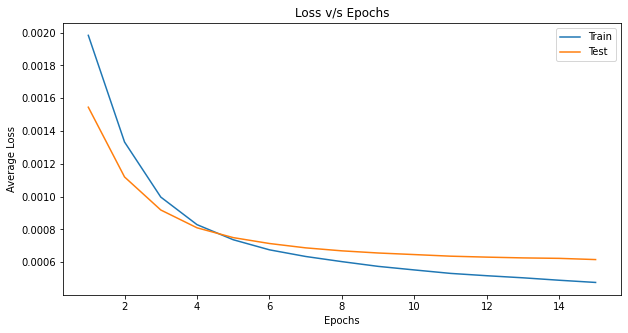

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,16)],[output_train_default[i][1] for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_test_default[i][1] for i in range(0,15)])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Loss v/s Epochs")
plt.legend(["Train","Test"])
plt.show()

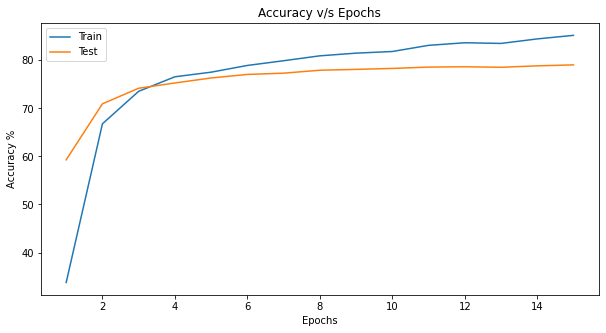

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,16)],[output_train_default[i][2].cpu().numpy() for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_test_default[i][2].cpu().numpy() for i in range(0,15)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs")
plt.legend(["Train","Test"])
plt.show()

# Bifurcation of ResNet Layers

In [ ]:
resnet_model = models.resnet50(pretrained=True)
param = resnet_model.state_dict()
for i in param.keys():
  print(i)

conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.bn3.running_mean
layer1.0.bn3.running_var
layer1.0.bn3.num_batches_tracked
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.0.downsample.1.running_mean
layer1.0.downsample.1.running_var
layer1.0.downsample.1.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tr

# Function to Finetune a Single Layer

In [ ]:
def selective_finetuning_single_layer(layer_name):
  resnet_model = models.resnet50(pretrained=True)
  for name, param in resnet_model.named_parameters():
    if param.requires_grad and layer_name in name:
      param.requires_grad = True
    else:
      param.requires_grad = False
  resnet_model.fc = torch.nn.Linear(2048,10)
  optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()))
  return resnet_model.cuda(), optimizer

In [ ]:
loss_function_fine_tune = torch.nn.CrossEntropyLoss().cuda()
resnet_finetune_1, optimizer_1 = selective_finetuning_single_layer('layer1')
resnet_finetune_2, optimizer_2 = selective_finetuning_single_layer('layer2')
resnet_finetune_3, optimizer_3 = selective_finetuning_single_layer('layer3')
resnet_finetune_4, optimizer_4 = selective_finetuning_single_layer('layer4')

In [ ]:
resnet_finetune_1,output_train_finetune_1,output_test_finetune_1 = model(train,test,15,resnet_finetune_1,loss_function_fine_tune,optimizer_1)
resnet_finetune_2,output_train_finetune_2,output_test_finetune_2 = model(train,test,15,resnet_finetune_2,loss_function_fine_tune,optimizer_2)
resnet_finetune_3,output_train_finetune_3,output_test_finetune_3 = model(train,test,15,resnet_finetune_3,loss_function_fine_tune,optimizer_3)
resnet_finetune_4,output_train_finetune_4,output_test_finetune_4 = model(train,test,15,resnet_finetune_4,loss_function_fine_tune,optimizer_4)

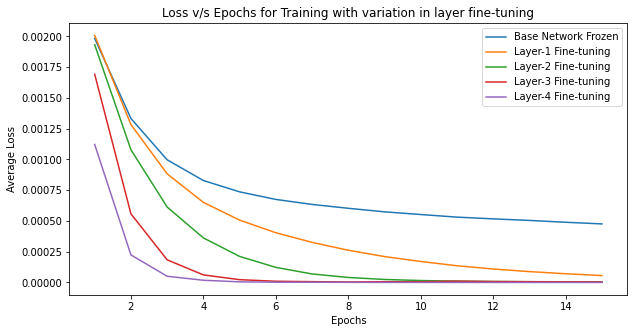

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,16)],[output_train_default[i][1] for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_train_finetune_1[i][1] for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_train_finetune_2[i][1] for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_train_finetune_3[i][1] for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_train_finetune_4[i][1] for i in range(0,15)])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Loss v/s Epochs for Training with variation in layer fine-tuning")
plt.legend(["Base Network Frozen","Layer-1 Fine-tuning","Layer-2 Fine-tuning","Layer-3 Fine-tuning","Layer-4 Fine-tuning"])
plt.show()

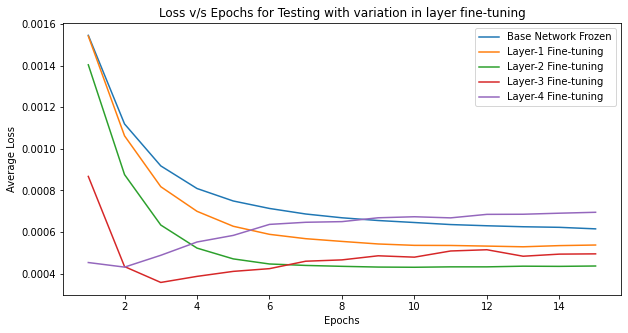

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,16)],[output_test_default[i][1] for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_test_finetune_1[i][1] for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_test_finetune_2[i][1] for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_test_finetune_3[i][1] for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_test_finetune_4[i][1] for i in range(0,15)])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Loss v/s Epochs for Testing with variation in layer fine-tuning")
plt.legend(["Base Network Frozen","Layer-1 Fine-tuning","Layer-2 Fine-tuning","Layer-3 Fine-tuning","Layer-4 Fine-tuning"])
plt.show()

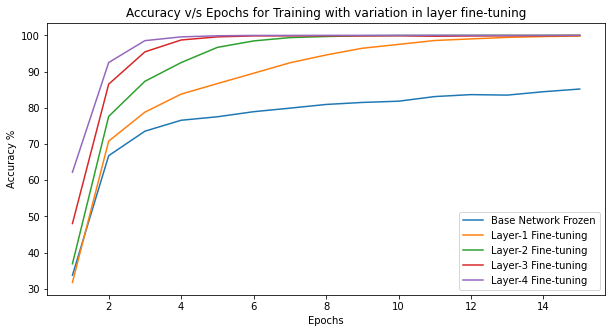

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,16)],[output_train_default[i][2].cpu().numpy() for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_train_finetune_1[i][2].cpu().numpy() for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_train_finetune_2[i][2].cpu().numpy() for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_train_finetune_3[i][2].cpu().numpy() for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_train_finetune_4[i][2].cpu().numpy() for i in range(0,15)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs for Training with variation in layer fine-tuning")
plt.legend(["Base Network Frozen","Layer-1 Fine-tuning","Layer-2 Fine-tuning","Layer-3 Fine-tuning","Layer-4 Fine-tuning"])
plt.show()

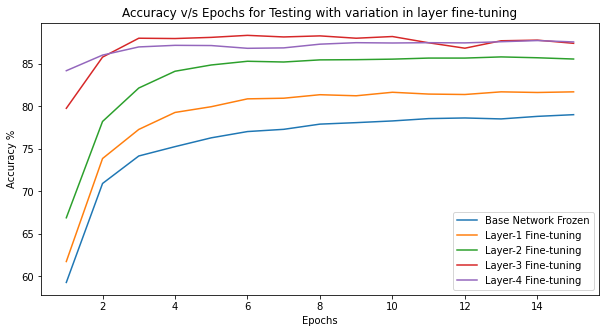

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,16)],[output_test_default[i][2].cpu().numpy() for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_test_finetune_1[i][2].cpu().numpy() for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_test_finetune_2[i][2].cpu().numpy() for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_test_finetune_3[i][2].cpu().numpy() for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_test_finetune_4[i][2].cpu().numpy() for i in range(0,15)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs for Testing with variation in layer fine-tuning")
plt.legend(["Base Network Frozen","Layer-1 Fine-tuning","Layer-2 Fine-tuning","Layer-3 Fine-tuning","Layer-4 Fine-tuning"])
plt.show()

# Function to Finetune multiple layers

In [ ]:
def selective_finetuning_multiple_layers(layer_list):
  resnet_model = models.resnet50(pretrained=True)
  for name, param in resnet_model.named_parameters():
    for layer_name in layer_list:
      if param.requires_grad and layer_name in name:
        param.requires_grad = True
      else:
        param.requires_grad = False
  resnet_model.fc = torch.nn.Linear(2048,10)
  optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()))
  return resnet_model.cuda(), optimizer

resnet_finetune_conv, optimizer_conv = selective_finetuning_multiple_layers(['conv1','conv2','conv3'])
resnet_finetune_bn, optimizer_bn = selective_finetuning_multiple_layers(['bn1','bn2','bn3'])
resnet_finetune_downsample, optimizer_downsample = selective_finetuning_multiple_layers('downsample')

In [ ]:
resnet_finetune_conv,output_train_finetune_conv,output_test_finetune_conv = model(train,test,15,resnet_finetune_conv,loss_function_fine_tune,optimizer_conv)
resnet_finetune_bn,output_train_finetune_bn,output_test_finetune_bn = model(train,test,15,resnet_finetune_bn,loss_function_fine_tune,optimizer_bn)
resnet_finetune_downsample,output_train_finetune_downsample,output_test_finetune_downsample = model(train,test,15,resnet_finetune_downsample,loss_function_fine_tune,optimizer_downsample)

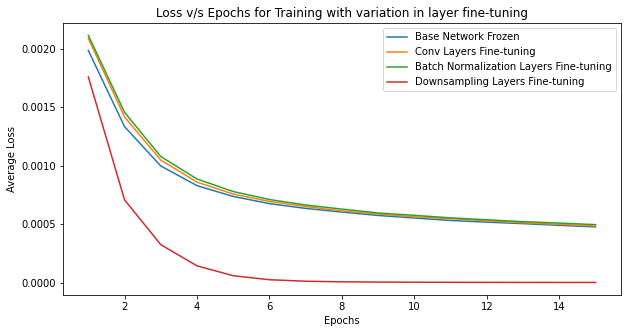

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,16)],[output_train_default[i][1] for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_train_finetune_conv[i][1] for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_train_finetune_bn[i][1] for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_train_finetune_downsample[i][1] for i in range(0,15)])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Loss v/s Epochs for Training with variation in layer fine-tuning")
plt.legend(["Base Network Frozen","Conv Layers Fine-tuning","Batch Normalization Layers Fine-tuning","Downsampling Layers Fine-tuning"])
plt.show()

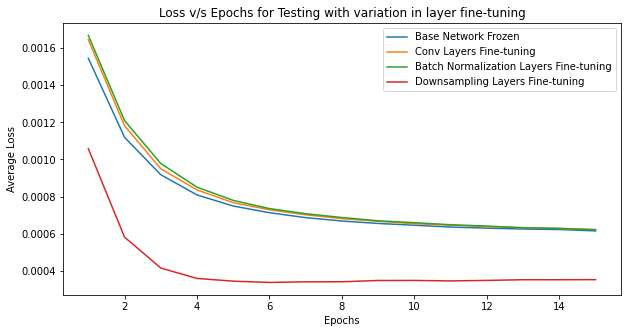

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,16)],[output_test_default[i][1] for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_test_finetune_conv[i][1] for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_test_finetune_bn[i][1] for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_test_finetune_downsample[i][1] for i in range(0,15)])
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Loss v/s Epochs for Testing with variation in layer fine-tuning")
plt.legend(["Base Network Frozen","Conv Layers Fine-tuning","Batch Normalization Layers Fine-tuning","Downsampling Layers Fine-tuning"])
plt.show()

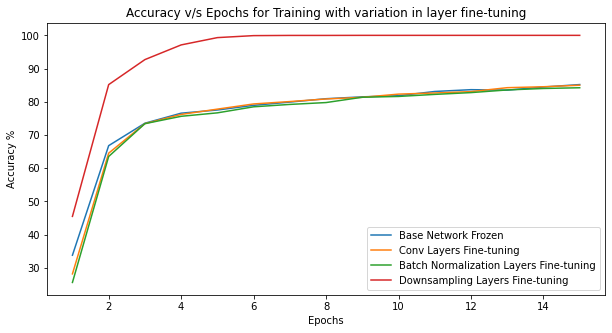

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,16)],[output_train_default[i][2].cpu().numpy() for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_train_finetune_conv[i][2].cpu().numpy() for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_train_finetune_bn[i][2].cpu().numpy() for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_train_finetune_downsample[i][2].cpu().numpy() for i in range(0,15)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs for Training with variation in layer fine-tuning")
plt.legend(["Base Network Frozen","Conv Layers Fine-tuning","Batch Normalization Layers Fine-tuning","Downsampling Layers Fine-tuning"])
plt.show()

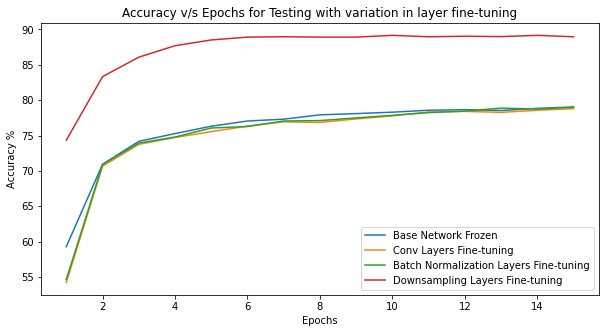

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([j for j in range(1,16)],[output_test_default[i][2].cpu().numpy() for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_test_finetune_conv[i][2].cpu().numpy() for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_test_finetune_bn[i][2].cpu().numpy() for i in range(0,15)])
plt.plot([j for j in range(1,16)],[output_test_finetune_downsample[i][2].cpu().numpy() for i in range(0,15)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs for Testing with variation in layer fine-tuning")
plt.legend(["Base Network Frozen","Conv Layers Fine-tuning","Batch Normalization Layers Fine-tuning","Downsampling Layers Fine-tuning"])
plt.show()

# Function to calculate Confusion Matrix, Class-Wise Accuracy and Mean-Classwise Accuracy

In [ ]:
def second_question_subparts(model_class, test_loader):
  pred = []
  true = []
  with torch.no_grad():
    for (image, label) in test_loader:
      image = image.cuda()
      label = label.cuda()
      for jj in label:
        true.append(jj.cpu().item())
      out = model_class(image)
      predicted_test = out.data.max(1, keepdim=True)[1]
      for j in predicted_test:
        pred.append(j.cpu().item())
  length = max(true)
  confusion_matrix = [[0 for i in range(length)] for j in range(length)]
  for row in range(0,len(true)):
    column = pred[row]
    confusion_matrix[true[row]-1][pred[row]-1] +=1
  print("Confusion Matrix\n")
  for i in confusion_matrix:
    print(i)
  mean_acc = 0
  print("\nClass-Wise Accuracy\n")
  for idx in range(length):
    tp = confusion_matrix[idx][idx]
    overall = sum(confusion_matrix[idx])
    output = tp/overall
    mean_acc += output
    print('For Class-'+str(idx)+' :- '+str(output*100)+'%\n')
  print('Mean Class-Wise Accuracy :-'+str(mean_acc*100/length)+'%\n')
  correct=0
  for i in range(length):
    correct += confusion_matrix[i][i]
  print('Overall Accuracy :-'+str(correct*100/len(true))+"%")

In [ ]:
second_question_subparts(resnet_model_default, test)

Confusion Matrix

[660, 1, 31, 22, 17, 7, 49, 3, 10]
[1, 705, 2, 1, 0, 4, 1, 8, 78]
[21, 0, 558, 78, 74, 14, 44, 6, 5]
[20, 1, 52, 627, 27, 46, 20, 2, 5]
[12, 1, 67, 31, 566, 72, 42, 0, 9]
[13, 8, 22, 43, 78, 593, 17, 5, 21]
[20, 1, 58, 47, 27, 7, 635, 0, 5]
[2, 6, 4, 1, 1, 2, 0, 665, 119]
[9, 57, 5, 6, 10, 10, 6, 132, 1365]

Class-Wise Accuracy

For Class-0 :- 82.5%

For Class-1 :- 88.125%

For Class-2 :- 69.75%

For Class-3 :- 78.375%

For Class-4 :- 70.75%

For Class-5 :- 74.125%

For Class-6 :- 79.375%

For Class-7 :- 83.125%

For Class-8 :- 85.3125%

Mean Class-Wise Accuracy :-79.04861111111111%

Overall Accuracy :-79.675%


In [ ]:
second_question_subparts(resnet_finetune_1, test)

Confusion Matrix

[657, 0, 49, 21, 13, 10, 30, 3, 17]
[1, 711, 1, 0, 0, 3, 0, 10, 74]
[17, 1, 589, 65, 64, 16, 41, 3, 4]
[21, 2, 46, 654, 17, 39, 15, 1, 5]
[16, 0, 67, 21, 582, 72, 34, 2, 6]
[15, 8, 12, 33, 49, 641, 18, 3, 21]
[16, 1, 47, 38, 26, 19, 647, 4, 2]
[0, 7, 2, 1, 0, 0, 0, 697, 93]
[8, 55, 5, 2, 2, 7, 4, 126, 1391]

Class-Wise Accuracy

For Class-0 :- 82.125%

For Class-1 :- 88.875%

For Class-2 :- 73.625%

For Class-3 :- 81.75%

For Class-4 :- 72.75%

For Class-5 :- 80.125%

For Class-6 :- 80.875%

For Class-7 :- 87.125%

For Class-8 :- 86.9375%

Mean Class-Wise Accuracy :-81.57638888888889%

Overall Accuracy :-82.1125%


In [ ]:
second_question_subparts(resnet_finetune_2, test)

Confusion Matrix

[674, 0, 42, 14, 15, 9, 18, 0, 28]
[0, 717, 1, 1, 0, 1, 0, 6, 74]
[17, 0, 627, 51, 58, 8, 32, 1, 6]
[16, 1, 35, 691, 17, 21, 11, 0, 8]
[10, 0, 43, 30, 621, 52, 36, 2, 6]
[4, 3, 10, 20, 51, 683, 11, 3, 15]
[12, 0, 45, 22, 20, 5, 692, 1, 3]
[2, 3, 0, 1, 0, 0, 0, 745, 49]
[6, 45, 2, 3, 1, 3, 1, 89, 1450]

Class-Wise Accuracy

For Class-0 :- 84.25%

For Class-1 :- 89.625%

For Class-2 :- 78.375%

For Class-3 :- 86.375%

For Class-4 :- 77.625%

For Class-5 :- 85.375%

For Class-6 :- 86.5%

For Class-7 :- 93.125%

For Class-8 :- 90.625%

Mean Class-Wise Accuracy :-85.76388888888889%

Overall Accuracy :-86.25%


In [ ]:
second_question_subparts(resnet_finetune_3, test)

Confusion Matrix

[697, 0, 36, 9, 15, 4, 33, 3, 3]
[1, 739, 1, 1, 1, 2, 2, 1, 52]
[14, 0, 629, 30, 80, 3, 41, 1, 2]
[11, 1, 35, 700, 20, 28, 5, 0, 0]
[9, 0, 46, 22, 629, 41, 48, 2, 3]
[10, 2, 7, 20, 55, 692, 7, 1, 6]
[9, 0, 28, 26, 21, 7, 707, 2, 0]
[0, 2, 3, 0, 0, 0, 0, 743, 52]
[14, 42, 2, 4, 6, 7, 1, 45, 1479]

Class-Wise Accuracy

For Class-0 :- 87.125%

For Class-1 :- 92.375%

For Class-2 :- 78.625%

For Class-3 :- 87.5%

For Class-4 :- 78.625%

For Class-5 :- 86.5%

For Class-6 :- 88.375%

For Class-7 :- 92.875%

For Class-8 :- 92.4375%

Mean Class-Wise Accuracy :-87.15972222222223%

Overall Accuracy :-87.6875%


In [ ]:
second_question_subparts(resnet_finetune_4, test)

Confusion Matrix

[726, 0, 33, 8, 9, 1, 13, 1, 9]
[0, 748, 5, 2, 4, 1, 0, 1, 39]
[23, 0, 621, 44, 73, 7, 32, 0, 0]
[11, 1, 39, 697, 18, 17, 16, 0, 1]
[14, 2, 54, 30, 597, 66, 33, 2, 2]
[5, 2, 10, 26, 45, 693, 14, 0, 5]
[17, 1, 32, 15, 14, 7, 714, 0, 0]
[0, 2, 3, 1, 0, 0, 0, 747, 47]
[4, 35, 9, 3, 3, 11, 6, 49, 1480]

Class-Wise Accuracy

For Class-0 :- 90.75%

For Class-1 :- 93.5%

For Class-2 :- 77.625%

For Class-3 :- 87.125%

For Class-4 :- 74.625%

For Class-5 :- 86.625%

For Class-6 :- 89.25%

For Class-7 :- 93.375%

For Class-8 :- 92.5%

Mean Class-Wise Accuracy :-87.26388888888889%

Overall Accuracy :-87.7875%


In [ ]:
second_question_subparts(resnet_finetune_conv, test)

Confusion Matrix

[660, 2, 28, 22, 18, 5, 47, 2, 16]
[1, 698, 2, 1, 1, 3, 1, 11, 82]
[22, 1, 557, 87, 64, 18, 41, 5, 5]
[19, 1, 50, 628, 25, 53, 16, 1, 7]
[13, 1, 69, 34, 546, 87, 39, 1, 10]
[13, 7, 19, 42, 57, 623, 17, 3, 19]
[22, 0, 55, 56, 23, 11, 626, 0, 7]
[5, 5, 3, 1, 0, 3, 0, 668, 115]
[11, 54, 6, 7, 7, 12, 6, 146, 1351]

Class-Wise Accuracy

For Class-0 :- 82.5%

For Class-1 :- 87.25%

For Class-2 :- 69.625%

For Class-3 :- 78.5%

For Class-4 :- 68.25%

For Class-5 :- 77.875%

For Class-6 :- 78.25%

For Class-7 :- 83.5%

For Class-8 :- 84.4375%

Mean Class-Wise Accuracy :-78.90972222222223%

Overall Accuracy :-79.4625%


In [ ]:
second_question_subparts(resnet_finetune_bn, test)

Confusion Matrix

[676, 2, 23, 24, 18, 7, 37, 3, 10]
[1, 705, 2, 1, 0, 5, 0, 11, 75]
[25, 0, 552, 83, 70, 18, 41, 5, 6]
[25, 1, 52, 623, 22, 53, 17, 2, 5]
[15, 1, 69, 24, 565, 82, 33, 2, 9]
[15, 8, 25, 33, 63, 621, 10, 4, 21]
[27, 1, 55, 53, 27, 11, 618, 3, 5]
[4, 5, 3, 1, 0, 2, 0, 691, 94]
[10, 62, 6, 7, 9, 13, 4, 170, 1319]

Class-Wise Accuracy

For Class-0 :- 84.5%

For Class-1 :- 88.125%

For Class-2 :- 69.0%

For Class-3 :- 77.875%

For Class-4 :- 70.625%

For Class-5 :- 77.625%

For Class-6 :- 77.25%

For Class-7 :- 86.375%

For Class-8 :- 82.4375%

Mean Class-Wise Accuracy :-79.3125%

Overall Accuracy :-79.625%


In [ ]:
second_question_subparts(resnet_finetune_downsample, test)

Confusion Matrix

[737, 0, 23, 5, 9, 2, 18, 1, 5]
[0, 759, 1, 2, 0, 3, 0, 2, 33]
[15, 0, 648, 42, 61, 6, 23, 3, 2]
[13, 1, 34, 712, 10, 23, 6, 0, 1]
[13, 0, 52, 16, 638, 55, 23, 2, 1]
[4, 1, 12, 19, 47, 708, 6, 0, 3]
[14, 0, 28, 22, 18, 8, 709, 1, 0]
[1, 1, 0, 0, 0, 0, 0, 752, 46]
[5, 45, 1, 1, 1, 6, 2, 62, 1477]

Class-Wise Accuracy

For Class-0 :- 92.125%

For Class-1 :- 94.875%

For Class-2 :- 81.0%

For Class-3 :- 89.0%

For Class-4 :- 79.75%

For Class-5 :- 88.5%

For Class-6 :- 88.625%

For Class-7 :- 94.0%

For Class-8 :- 92.3125%

Mean Class-Wise Accuracy :-88.90972222222223%

Overall Accuracy :-89.25%
